In [1]:
import nibabel as nib 
! pip install nibabel --user
import os
import glob
import numpy as np
from nibabel.testing import data_path
import matplotlib.pyplot as plt
#import cv2
#! pip install cv2 --user
import time
from datetime import datetime
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.ndimage import zoom
import pandas as pd
import os
from skimage.io import imread
from skimage.color import gray2rgb
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torchvision as tv
from torch.utils.data import (
    Dataset,
    DataLoader,
)
import matplotlib.pyplot as plt
from torch.utils import data as DT
from skimage.transform import radon , iradon
%matplotlib inline
!pip install livelossplot --quiet
from livelossplot import PlotLosses
from sklearn.metrics import r2_score , mean_squared_error

In [2]:
def pad(img_,size_):
    dif=size_-img_.shape[0]
    if dif%2==0:
        img_=np.pad(img_,((dif//2,dif//2),(0,0),(0,0)),'edge')
    else:
        img_=np.pad(img_,(((dif-1)//2,(dif+1)//2),(0,0),(0,0)),'edge')
    dif=size_-img_.shape[1]
    if dif%2==0:
        img_=np.pad(img_,((0,0),(dif//2,dif//2),(0,0)),'edge')
    else:
        img_=np.pad(img_,((0,0),((dif-1)//2,(dif+1)//2),(0,0)),'edge')
    dif=size_-img_.shape[2]
    if dif%2==0:
        img_=np.pad(img_,((0,0),(0,0),(dif//2,dif//2)),'edge')
    else:
        img_=np.pad(img_,((0,0),(0,0),((dif-1)//2,(dif+1)//2)),'edge')
    return img_

In [3]:

def save_checkpoint(state, filename="my_checkpoint_V3.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [4]:
path = 'D:\\Master_courses\\Praktikum\\challenge\\hecktor\\data\\resampled\\'

files = [f for f in glob.glob(path + "**/*_ct_gtvt.nii.gz", recursive=True)]
labels_lenght=list()
image_list=list()
label_list=list()

for idx,f in enumerate(files):
    SEG_img = nib.load(f)
    SEG_data = SEG_img.get_fdata()
    if SEG_data.shape!=(64,64,64):
        SEG_data=pad(SEG_data,64)
    label_list.append(SEG_data)
    path=f[:-15]+'_pt.nii.gz'
    im=nib.load(path)
    PET_data=im.get_fdata()
    if PET_data.shape!=(64,64,64):
        PET_data=pad(PET_data,64)
    image_list.append(PET_data)
    #print(idx)


In [5]:
len(image_list) # number of patients

200

In [6]:
print (image_list[0].shape)

(64, 64, 64)


In [7]:
size = 16 # patch size
stride = 16 # patch stride

all_labels=list()
for seg_img in label_list:
    positive_cells_number=np.sum(seg_img)
    #print("positive_cells_number",positive_cells_number)
    patches = torch.from_numpy(seg_img).unfold(0, size, stride).unfold(1, size, stride).unfold(2, size, stride)
    reshaped_patches=patches.reshape(-1,size,size,size)
    labels_=(torch.sum(reshaped_patches , dim=(1,2,3)).int().numpy())/positive_cells_number
    #print ("labels_", labels_)
    all_labels.append(labels_)
all_labels=np.asarray(all_labels).reshape(-1)

In [8]:
all_labels[:64] # labels of one patient

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00208671, 0.008115  , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00139114,
       0.        , 0.        , 0.11245073, 0.69116624, 0.03524229,
       0.        , 0.01738929, 0.10479944, 0.00092743, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02643172,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

In [9]:
all_PET_patches=list()
for PET_img in image_list:
    patches = torch.from_numpy(PET_img).unfold(0, size, stride).unfold(1, size, stride).unfold(2, size, stride)
    reshaped_patches=patches.reshape(-1,size,size,size).numpy()
    all_PET_patches.append(reshaped_patches)
all_PET_patches=np.asarray(all_PET_patches).reshape(-1,size,size,size)

In [10]:
print (all_PET_patches.shape) #number of patches * pactch dim1 * patch dim2 * patch dim3
patch_mean=np.mean(all_PET_patches , axis=0)
patch_std=np.std(all_PET_patches , axis=0)

(12800, 16, 16, 16)


In [11]:
class HN_Dataset(Dataset):
    def __init__(self, transform=tv.transforms.Compose(tv.transforms.ToTensor())):
        self.labels = all_labels
        self.images=all_PET_patches
        self.transform = transform
        self.mode='None'
    def __len__(self):
        return len(all_labels)

    def __getitem__(self, idx):

        label= torch.from_numpy(np.asarray(self.labels[idx]))
        
        if self.transform is not None:
            PET_data = self.transform(self.images[idx])
        return (PET_data, label)

In [51]:
split_threshold=10000  # to split test and train set
batch_size = 64

# Load Data

idx = list(range(len(all_labels)))

dataset = HN_Dataset( transform=tv.transforms.ToTensor())
train_set = DT.Subset(dataset, idx[:split_threshold])
test_set = DT.Subset(dataset, idx[split_threshold:])

#train_set, test_set = torch.utils.data.random_split(dataset, [10000, 2800])

train_set.transform= tv.transforms.Compose([#tv.transforms.RandomHorizontalFlip(),
                                            #tv.transforms.RandomVerticalFlip(),
                                            tv.transforms.ToTensor()
                                            #tv.transforms.Normalize(patch_mean, patch_std)
                                           ])

#tv.transforms.RandomRotation(180),

#train_loader = DataLoader(train_set, batch_size=batch_size, sampler= sampler)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


In [52]:

dataIter = iter(train_loader)
imgs, labels = dataIter.next()


print ("labels", labels)


labels tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.3491, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2213, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], dtype=torch.float64)


In [53]:
class CNN_conv2d(nn.Module):
    def __init__(self, in_channels=16, num_classes=1):
        super(CNN_conv2d, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=(3,3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=16,
            kernel_size=(3 ,3),
            stride=(1, 1),
            #padding=(1, 1),
        )
        self.conv3 = nn.Conv2d(
            in_channels=16,
            out_channels=8,
            kernel_size=(3 ,3),
            stride=(1, 1),
            #padding=(1, 1),
        )

        
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        self.fc1 = nn.Linear(16 * 3 * 3, num_classes)
        self.fc2 = nn.Linear(8, num_classes)
        
        self.sig=nn.Sigmoid()
        
        self.BatchNorm64=nn.BatchNorm2d(64)
        self.BatchNorm32=nn.BatchNorm2d(32)
        self.BatchNorm8=nn.BatchNorm2d(8)
        self.BatchNorm128=nn.BatchNorm2d(128)
        self.BatchNorm16=nn.BatchNorm2d(16)
        self.layernorm1=nn.LayerNorm((64, 16, 16))
        self.layernorm2=nn.LayerNorm((32, 8, 8))
        self.layernorm3=nn.LayerNorm((16, 4, 4))
        self.dropout= nn.Dropout(p=0.25)
        self.initialize_weights()

        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        #x= self.layernorm1(x)
        x = self.BatchNorm32(x)
        x = self.pool(x)
        x = F.leaky_relu(self.conv2(x))
        x = self.BatchNorm16(x)
        #x= self.layernorm2(x)
        x = self.pool(x)
        x=self.dropout(x)
        #x = F.leaky_relu(self.conv3(x))
        #x = self.BatchNorm8(x)
        #x= self.layernorm3(x)
        #x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        #x = self.fc2(x)
        x=self.sig(x)
        return x

    

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)

                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)


In [54]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
#in_channel = 32
#num_classes = 2
num_epochs = 100
learning_rate = 1e-3
batch_size = 64

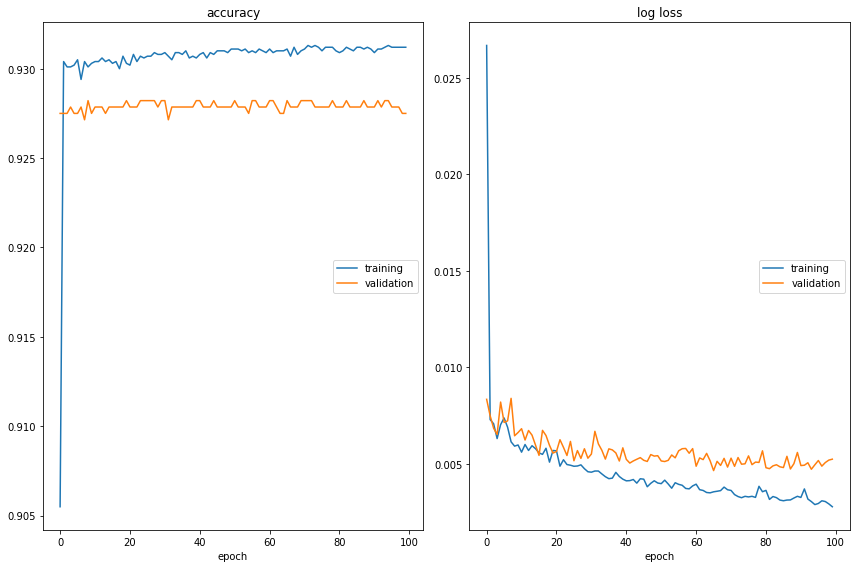

accuracy
	training         	 (min:    0.905, max:    0.931, cur:    0.931)
	validation       	 (min:    0.927, max:    0.928, cur:    0.928)
log loss
	training         	 (min:    0.003, max:    0.027, cur:    0.003)
	validation       	 (min:    0.005, max:    0.008, cur:    0.005)


In [55]:
#device=torch.device("cpu")
# Initialize network
model = CNN_conv2d().to(device)
liveloss = PlotLosses()

# Loss and optimizer
criterion=nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

load_module=False
ref=1

dataloaders = {
    "train": train_loader,
    "validation": test_loader
}

# Train Network
for epoch in range(num_epochs):
    logs = {}
    for phase in ['train', 'validation']:

        if phase == 'train':
            model.train()
        else:
            model.eval()

            
        running_loss = 0.0
        running_corrects = 0.0
        #now = datetime.now()

        #losses = []
        for inputs, labels in dataloaders[phase]:
            # Get data to cuda if possible
            inputs = inputs.to(device=device)
            labels = labels.to(device=device)

            # forward
            inputs=inputs.float()
            scores = model(inputs)
            labels=labels.float()
            scores=scores.view(-1)

            loss = criterion(scores, labels)
            #losses.append(loss.item())
            #if phase=='validation':
            #    print (loss)
            # backward
            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                # gradient descent or adam step
                optimizer.step()
            preds=torch.round(scores)
    
            running_loss += loss.detach() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
        
        if phase == 'validation':
            this_loss=(running_loss / len(dataloaders[phase].dataset)).item()
            if this_loss<ref:
                checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
                # save checkpoint
                save_checkpoint(checkpoint)
                ref=this_loss
                print ("epoch {}:loss{}".format(epoch,ref))  
        
        prefix = ''
        if phase == 'validation':
            prefix = 'val_'

        logs[prefix + 'log loss'] = epoch_loss.item()
        #logs[prefix + 'log'] = epoch_loss.item()

        logs[prefix + 'accuracy'] = epoch_acc.item()
        
    liveloss.update(logs)
    liveloss.send()



In [56]:
#load_checkpoint(torch.load("my_checkpoint_V3.pth.tar"), model, optimizer)


In [57]:
#MAIN
#device = torch.device("cpu")
num_epochs = 81
# Initialize network
model = CNN_conv2d().to(device)
#model = model.float()

# Loss and optimizer

criterion=nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
load_module=False
print("Current Time =", datetime.now().strftime("%H:%M:%S")) 
# Train Network
for epoch in range(num_epochs):
    now = datetime.now()
    if load_module:
        # load checkpoint
        load_checkpoint(torch.load("my_checkpoint_V3_percent.pth.tar"), model, optimizer)
        load_module=False
    losses = []
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        data=data.float()
        scores = model(data)
        targets=targets.float()
        scores=scores.view(-1)

        loss = criterion(scores, targets)
        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
    if (epoch % 20==0):
        print(f"Cost at epoch {epoch} is {np.sum(losses)/len(losses)}")
        print("Current Time =", now.strftime("%H:%M:%S")) 
        checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
        # save checkpoint
        save_checkpoint(checkpoint)
        


Current Time = 13:50:21
Cost at epoch 0 is 0.0183142597244305
Current Time = 13:50:21
=> Saving checkpoint
Cost at epoch 20 is 0.005691754540934036
Current Time = 13:51:25
=> Saving checkpoint
Cost at epoch 40 is 0.004529902077482785
Current Time = 13:52:38
=> Saving checkpoint
Cost at epoch 60 is 0.003815727552670057
Current Time = 13:53:41
=> Saving checkpoint
Cost at epoch 80 is 0.0035916067717599114
Current Time = 13:54:45
=> Saving checkpoint


In [58]:
# Check accuracy on training to see how good our model is
total_mse=0
def check_accuracy(loader, model, test_set):
    #s=nn.Sigmoid()

    true_positives,false_positives,true_negatives,false_negatives=0,0,0,0

    num_correct = 0
    num_samples = 0
    model.eval()
    j=0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x=x.float()
            scores = model(x)
            #scores=s(scores)
            #predictions=torch.round(scores).view(-1)
            predictions=scores
            MSE=mean_squared_error(np.ravel(predictions.cpu().numpy()),np.ravel(y.cpu().numpy()))
            total_mse=+MSE
            if test_set:
                #imshow(x.cpu())
                #print ("labels:       ",(y.cpu()))
                #print ("predictions:  ",(predictions.cpu()))
                
                np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
                
                print ("labels:       ",np.ravel(y.cpu().numpy()))
                print ("predictions:  ",np.ravel((predictions.cpu().numpy())))
                print ("mean_squared_error",MSE)
                #print ("r2_score",r2_score(np.ravel(predictions.cpu().numpy()),np.ravel(y.cpu().numpy())))

    print ("total_mse",total_mse)
        
    model.train()



In [59]:
print("Checking accuracy on Training Set")
check_accuracy(train_loader, model ,test_set=False)

print("Checking accuracy on Test Set")
check_accuracy(test_loader, model, test_set=False)

Checking accuracy on Training Set
total_mse 0.0007855740505537817
Checking accuracy on Test Set
total_mse 0.0024130344690644896


In [60]:
print("Checking accuracy on Test Set")
check_accuracy(test_loader, model, test_set=True)

Checking accuracy on Test Set
labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.034  0.455  0.014  0.000  0.117  0.297  0.005  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.040  0.000
  0.000  0.000  0.038  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.017  0.003  0.000  0.003  0.013  0.006  0.003  0.084
  0.030  0.001  0.014  0.002  0.001  0.000  0.000  0.002  0.046  0.024
  0.000  0.001  0.309  0.041  0.007  0.034  0.272  0.004  0.026  0.003
  0.001  0.000  0.000  0.000  0.000  0.000  0.000  0.001  0.004  0.006
  0.002  0.028  0.194  0.005  0.001  0.001  0.001  0.001  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.001  0.001  0.000  0.000  0.001
  0.001  0.000  0.000  0.000]
mean_squared_error 0.0010783

predictions:   [ 0.000  0.001  0.071  0.007  0.000  0.111  0.026  0.009  0.008  0.034
  0.050  0.011  0.001  0.002  0.007  0.000  0.000  0.004  0.037  0.001
  0.004  0.013  0.034  0.021  0.042  0.020  0.073  0.013  0.002  0.003
  0.006  0.001  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.001
  0.002  0.001  0.021  0.021  0.004  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.007  0.011  0.001  0.001  0.001  0.005
  0.001  0.001  0.001  0.001]
mean_squared_error 0.006237626580398465
labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000]
predictions:   [ 0

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.311  0.274  0.000  0.000  0.224
  0.179  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.009  0.001  0.000  0.000  0.002  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.002  0.001  0.000  0.101  0.113  0.002  0.005  0.138
  0.082  0.001  0.000  0.000  0.000  0.021  0.000  0.001  0.003  0.000
  0.000  0.004  0.014  0.001  0.005  0.007  0.007  0.001  0.000  0.001
  0.011  0.009  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.001  0.002  0.000  0.000  0.000  0.005  0.000  0.000
  0.000  0.000  0.000  0.000  0.002  0.001  0.000  0.000  0.000  0.002
  0.000  0.000  0.000  0.000]
mean_squared_error 0.001375750684734802
labels:        [ 0

In [61]:
PEAK=200

def make_noisy_image(image):
    img=np.zeros(image.shape)
    for idx, _2d_img in enumerate(image):  
        
        theta = np.linspace(0., 180., max(_2d_img.shape), endpoint=False)
        sinogram = radon(_2d_img, theta=theta, circle=False)
        sinogram=np.clip(sinogram, 0,None)
        noisy = np.random.poisson(sinogram * PEAK)/PEAK  
        img[idx] = iradon(noisy, theta=theta, circle=False)
    return img

In [62]:

path = 'D:\\Master_courses\\Praktikum\\challenge\\hecktor\\data\\resampled\\'
#_ct_gtvt.nii.gz
#_pt.nii.gz
files = [f for f in glob.glob(path + "**/*_pt.nii.gz", recursive=True)]
noisy_image_list=list()

for idx,f in enumerate(files):
    
    im=nib.load(f)
    PET_data=im.get_fdata()   
    if PET_data.shape!=(64,64,64):
        PET_data=pad(PET_data,64)
    PET_data=make_noisy_image(PET_data)   
    noisy_image_list.append(PET_data)


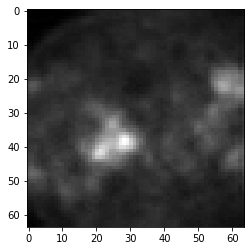

In [68]:
fig = plt.figure()
imgplot = plt.imshow(noisy_image_list[0][:,:,50],cmap='gray')

In [63]:
all_noisy_PET_patches=list()
for PET_img in noisy_image_list:
    patches = torch.from_numpy(PET_img).unfold(0, size, stride).unfold(1, size, stride).unfold(2, size, stride)
    reshaped_patches=patches.reshape(-1,size,size,size).numpy()
    all_noisy_PET_patches.append(reshaped_patches)
all_noisy_PET_patches=np.asarray(all_noisy_PET_patches).reshape(-1,size,size,size)

In [64]:
class noisy_HN_Dataset(Dataset):
    def __init__(self, transform=tv.transforms.Compose(tv.transforms.ToTensor())):
        self.labels = all_labels
        self.images=all_noisy_PET_patches
        self.transform = transform
        self.mode='None'
    def __len__(self):
        return len(all_labels)

    def __getitem__(self, idx):

        label= torch.from_numpy(np.asarray(self.labels[idx]))
        
        if self.transform is not None:
            PET_data = self.transform(self.images[idx])
        return (PET_data, label)

In [65]:
split_threshold=10000
idx = list(range(len(all_labels)))

noisy_dataset = noisy_HN_Dataset( transform=tv.transforms.ToTensor())
noisy_train_set = DT.Subset(noisy_dataset, idx[:split_threshold])
noisy_test_set = DT.Subset(noisy_dataset, idx[split_threshold:])

#train_set, test_set = torch.utils.data.random_split(dataset, [10000, 2800])

#train_loader = DataLoader(train_set, batch_size=batch_size, sampler= sampler
#noisy_train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
noisy_test_loader = DataLoader(noisy_test_set, batch_size=batch_size, shuffle=False)

In [66]:
print("Checking accuracy on Test Set")
check_accuracy(noisy_test_loader, model, test_set=False)

Checking accuracy on Test Set
total_mse 0.0023771466927940076


In [67]:
print("Checking accuracy on Test Set")
check_accuracy(test_loader, model, test_set=True)

Checking accuracy on Test Set
labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.034  0.455  0.014  0.000  0.117  0.297  0.005  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.040  0.000
  0.000  0.000  0.038  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.017  0.003  0.000  0.003  0.013  0.006  0.003  0.084
  0.030  0.001  0.014  0.002  0.001  0.000  0.000  0.002  0.046  0.024
  0.000  0.001  0.309  0.041  0.007  0.034  0.272  0.004  0.026  0.003
  0.001  0.000  0.000  0.000  0.000  0.000  0.000  0.001  0.004  0.006
  0.002  0.028  0.194  0.005  0.001  0.001  0.001  0.001  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.001  0.001  0.000  0.000  0.001
  0.001  0.000  0.000  0.000]
mean_squared_error 0.0010783

predictions:   [ 0.000  0.000  0.103  0.012  0.000  0.005  0.061  0.002  0.010  0.009
  0.025  0.006  0.014  0.012  0.003  0.004  0.000  0.000  0.043  0.011
  0.000  0.005  0.908  0.015  0.018  0.013  0.122  0.006  0.042  0.012
  0.008  0.002  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.001
  0.000  0.000  0.001  0.015  0.000  0.000  0.000  0.000  0.000  0.000
  0.001  0.000  0.000  0.000  0.000  0.001  0.000  0.001  0.098  0.055
  0.002  0.000  0.001  0.000]
mean_squared_error 0.001830867554980432
labels:        [ 0.000  0.000  0.000  0.000  0.000  0.025  0.178  0.000  0.000  0.171
  0.627  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000]
predictions:   [ 0

predictions:   [ 0.000  0.000  0.002  0.001  0.000  0.101  0.113  0.002  0.005  0.138
  0.082  0.001  0.000  0.000  0.000  0.021  0.000  0.001  0.003  0.000
  0.000  0.004  0.014  0.001  0.005  0.007  0.007  0.001  0.000  0.001
  0.011  0.009  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.001  0.002  0.000  0.000  0.000  0.005  0.000  0.000
  0.000  0.000  0.000  0.000  0.002  0.001  0.000  0.000  0.000  0.002
  0.000  0.000  0.000  0.000]
mean_squared_error 0.001375750684734802
labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.021  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.130  0.442  0.172  0.000  0.008  0.068  0.004  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.004  0.124  0.008
  0.000  0.000  0.019  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000]
predictions:   [ 0